In [2]:
import functions as fu
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh

import sparse as sp

In [3]:
def get_reduced_density_matrix(psi, loc_dim, n_sites, keep_indices,
    print_rho=False):
    """
    Parameters
    ----------
    psi : ndarray
        state of the Quantum Many-Body system
    loc_dim : int
        local dimension of each single site of the QMB system
    n_sites : int
        total number of sites in the QMB system
    keep_indices (list of ints):
        Indices of the lattice sites to keep.
    print_rho : bool, optional
        If True, it prints the obtained reduced density matrix], by default False

    Returns
    -------
    ndarray
        Reduced density matrix
    """
    if not isinstance(psi, np.ndarray):
        raise TypeError(f'density_mat should be an ndarray, not a {type(psi)}')

    if not np.isscalar(loc_dim) and not isinstance(loc_dim, int):
        raise TypeError(f'loc_dim must be an SCALAR & INTEGER, not a {type(loc_dim)}')

    if not np.isscalar(n_sites) and not isinstance(n_sites, int):
        raise TypeError(f'n_sites must be an SCALAR & INTEGER, not a {type(n_sites)}')

    # Ensure psi is reshaped into a tensor with one leg per lattice site
    psi_tensor = psi.reshape(*[loc_dim for _ in range(int(n_sites))])
    # Determine the environmental indices
    all_indices = list(range(n_sites))
    env_indices = [i for i in all_indices if i not in keep_indices]
    new_order = keep_indices + env_indices
    # Rearrange the tensor to group subsystem and environment indices
    psi_tensor = np.transpose(psi_tensor, axes=new_order)
    # print(f"Reordered psi_tensor shape: {psi_tensor.shape}")
    # Determine the dimensions of the subsystem and environment for the bipartition
    subsystem_dim = np.prod([loc_dim for i in keep_indices])
    env_dim = np.prod([loc_dim for i in env_indices])
    # Reshape the reordered tensor to separate subsystem from environment
    psi_partitioned = psi_tensor.reshape((subsystem_dim, env_dim))
    # Compute the reduced density matrix by tracing out the env-indices
    RDM = np.tensordot(psi_partitioned, np.conjugate(psi_partitioned), axes=([1], [1]))
    # Reshape rho to ensure it is a square matrix corresponding to the subsystem
    RDM = RDM.reshape((subsystem_dim, subsystem_dim))

    # PRINT RHO
    if print_rho:
        print('----------------------------------------------------')
        print(f'DENSITY MATRIX TRACING SITES ({str(env_indices)})')
        print('----------------------------------------------------')
        print(RDM)

    return RDM

## Close to the critical point

In [4]:
# Parametri
N_values = np.arange(4, 14, 1)  # Numero totale di spin (deve essere pari)
loc_dim = 2  # Dimensione locale per ogni spin
# l_values = np.linspace(0.5, 2.0, 50)  # Valori di λ

l = 0.9

l_critical = [0.6135347926800416, 0.6796124191837966, 0.7304964175730098, 0.7665184505949523, 0.7946959596847979, 0.8140540969222221, 0.8338837823948374, 0.849072399435249, 0.8593515294897932, 0.869755101835417, 0.8802846230085422]


entropies = []

for i,N in enumerate(N_values):
    print(N, l_critical[i])
    N = int(N)
    # Costruzione dell'Hamiltoniano
    H = sp.ising_hamiltonian(N, l)

    # Calcolo del ground state
    eigval, eigvec = eigsh(H, k=1, which='SA')
    ground_state = eigvec[:, 0]

    rho = np.outer(ground_state, np.conj(ground_state))


    keep_indices = list(range(N // 2))  # Mantengo i primi N/2 spin
    rhoA = get_reduced_density_matrix(ground_state, loc_dim, N, keep_indices)


    # SVD per ottenere i valori singolari
    U, Lambda, Vh = np.linalg.svd(rhoA, full_matrices=False)

    # Calcolo dell'entropia di entanglement
    entropy = -np.sum(Lambda**2 * np.log(Lambda**2))
    entropies.append(entropy)


4 0.6135347926800416
5 0.6796124191837966
6 0.7304964175730098
7 0.7665184505949523
8 0.7946959596847979
9 0.8140540969222221
10 0.8338837823948374
11 0.849072399435249
12 0.8593515294897932
13 0.869755101835417


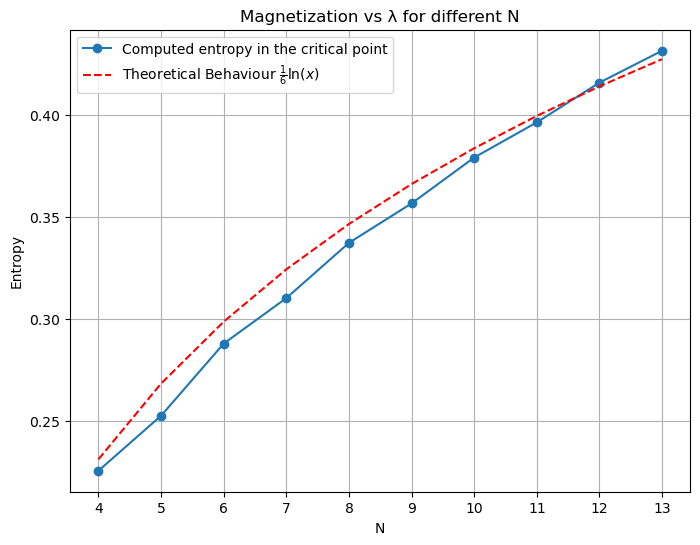

In [5]:
plt.figure(figsize=(8, 6))

y_theoretical = (1/6) * np.log(N_values)

plt.plot(N_values, entropies, '-o', label = "Computed entropy in the critical point")
plt.plot(N_values, y_theoretical, 'r--', label=r"Theoretical Behaviour $\frac{1}{6} \ln(x)$")


# plt.gca().invert_xaxis()
# plt.gca().invert_yaxis()
# plt.xscale('log')  # Scala logaritmica sull'asse x
plt.xlabel('N')
plt.ylabel('Entropy')
plt.title('Magnetization vs λ for different N')
x_min, x_max = min(N_values), max(N_values)  # Trova il range dei tuoi dati N_vals
plt.xticks(np.arange(x_min, x_max + 1, 1))  # Ticks da x_min a x_max con passo di 1
plt.legend()
plt.grid()
plt.show()

## Varying lambda

entropy vs $\lambda$. <br>

- For $\lambda >> 1$ or $\lambda << 1$: separable state and entropy close to 0, and entanglement is minimum
- For $\lambda \simeq 1$: generale state and entropy close to 0, and entanglement is maximum


In [6]:
N_vals = [8,9,10,11,12]
# l_vals = np.linspace(0, 20, 100)
l_vals = np.logspace(2, -2, 200)
loc_dim = 2


entropies_total = []


for N in N_vals:
    print(N)
    entropy_Ni = []

    for l in l_vals:
        N = int(N)
        # Costruzione dell'Hamiltoniano
        H = sp.ising_hamiltonian(N, l)

        # Calcolo del ground state
        eigval, eigvec = eigsh(H, k=1, which='SA')
        ground_state = eigvec[:, 0]

        rho = np.outer(ground_state, np.conj(ground_state))


        keep_indices = list(range(N // 2))  # Mantengo i primi N/2 spin
        rhoA = get_reduced_density_matrix(ground_state, loc_dim, N, keep_indices)


        # SVD per ottenere i valori singolari
        U, Lambda, Vh = np.linalg.svd(rhoA, full_matrices=False)

        # Calcolo dell'entropia di entanglement
        entropy = -np.sum(Lambda**2 * np.log(Lambda**2))

        entropy_Ni.append(entropy)
    
    entropies_total.append(entropy_Ni)

8
9
10
11
12


For N = 8, Maximum entropy at λ = 0.0401
For N = 9, Maximum entropy at λ = 0.0608
For N = 10, Maximum entropy at λ = 0.0732
For N = 11, Maximum entropy at λ = 0.0966
For N = 12, Maximum entropy at λ = 0.1110


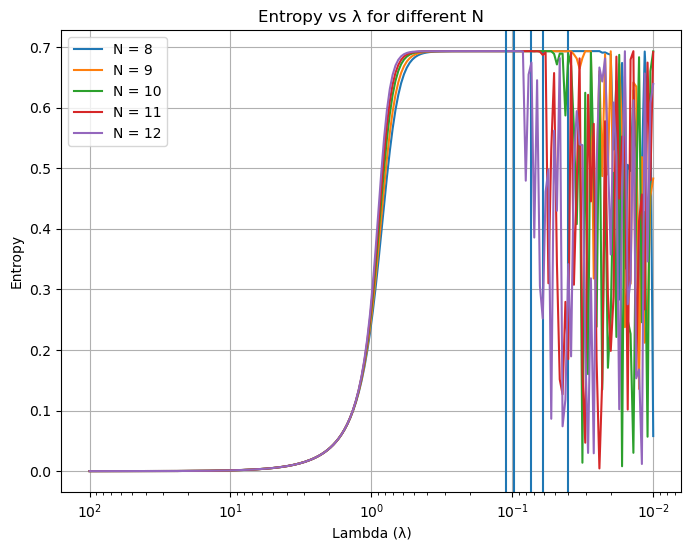

In [21]:
plt.figure(figsize=(8, 6))

max_lambda_values = [] 

for i, entr in enumerate(entropies_total): 
    max_index = np.argmax(entr)
    
    # Trova il corrispondente valore di l_vals
    max_lambda = l_vals[max_index]
    max_lambda_values.append(max_lambda)
    
    # Stampa il risultato
    print(f"For N = {i+8}, Maximum entropy at λ = {max_lambda:.4f}")

    plt.plot(l_vals, entr, label=f'N = {i+8}')
    plt.axvline(x=max_lambda)

plt.gca().invert_xaxis()
# plt.gca().invert_yaxis()
plt.xscale('log')  # Scala logaritmica sull'asse x
plt.xlabel('Lambda (λ)')
plt.ylabel('Entropy')
plt.title('Entropy vs λ for different N')
plt.legend()
plt.grid(True)
plt.show()
